In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# 输入daseCV所在的路径
# 'daseCV' 文件夹包括 '.py', 'classifiers' 和'datasets'文件夹
# 例如 'CV/assignments/assignment1/daseCV/'
FOLDERNAME = 'CV/assignments/assignment2/daseCV/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd daseCV/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/daseCV/datasets
--2021-04-24 11:47:22--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  82.9MB/s    in 2.0s    

2021-04-24 11:47:24 (82.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# Dropout
Dropout [1] 是一种通过在正向传播中将一些输出随机设置为零，神经网络正则化的方法。在这个练习中，你将实现一个dropout层，并修改你的全连接网络使其可选择的使用dropout

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [ ]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from daseCV.classifiers.fc_net import *
from daseCV.data_utils import get_CIFAR10_data
from daseCV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from daseCV.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout 正向传播
在文件 `daseCV/layers.py` 中完成dropout的正向传播过程。由于dropout在训练和测试期间的行为是不同的，因此请确保两种模式下都实现完成。

完成此操作后，运行下面的cell以测试你的代码。

In [ ]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout 反向传播
在文件 `daseCV/layers.py` 中完成dropout的反向传播。完成之后运行以下cell以对你的实现代码进行梯度检查。

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.892896954038074e-11


In [ ]:
np.random.seed(231)
np.random.rand(2,3)

array([[0.78149404, 0.58420912, 0.42671007],
       [0.31534469, 0.82688829, 0.90342948]])

In [ ]:
p=0.8

In [ ]:
np.random.seed(231)
(np.random.rand(2,3)<p)/p

array([[1.25, 1.25, 1.25],
       [1.25, 0.  , 0.  ]])

## 问题 1:
如果我们不利用inverted dropout，在训练的时候直接将dropout后的值除以 `p`,会发生什么？为什么会这样呢？



## 回答:
除了Mean of train-time output和Mean of test-time output会变，其他结果，反向传播的结果都不会变，因为对训练输出做整体的拉伸只要在test的时候拉伸回来，就相当于没操作。写成inverted dropout只是方便在test阶段不操作。


# 全连接网络的Dropout

修改`daseCV/classifiers/fc_net.py`文件完成使用dropout的部分。具体来说，如果网络的构造函数收到的`dropout`参数值不为1，则应在每个ReLU之后添加一个dropout层。完成之后，运行以下命令以对你的代码进行梯度检查。

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302454105929313
W1 relative error: 2.56e-07
W2 relative error: 2.10e-06
W3 relative error: 5.57e-08
b1 relative error: 6.43e-09
b2 relative error: 2.04e-09
b3 relative error: 1.10e-10

Running check with dropout =  0.5
Initial loss:  2.3030067920900876
W1 relative error: 1.22e-06
W2 relative error: 9.41e-08
W3 relative error: 2.67e-07
b1 relative error: 3.53e-08
b2 relative error: 3.37e-09
b3 relative error: 1.01e-10



# 正则化实验
作为实验，我们将在500个样本上训练一对双层网络：一个不使用dropout，另一个使用概率为0.25的dropout。之后，我们将可视化这两个网络训练和验证的准确度。

In [ ]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.236000; val_acc: 0.190000
(Epoch 1 / 25) train acc: 0.250000; val_acc: 0.178000
(Epoch 2 / 25) train acc: 0.360000; val_acc: 0.217000
(Epoch 3 / 25) train acc: 0.508000; val_acc: 0.242000
(Epoch 4 / 25) train acc: 0.526000; val_acc: 0.244000
(Epoch 5 / 25) train acc: 0.542000; val_acc: 0.286000
(Epoch 6 / 25) train acc: 0.594000; val_acc: 0.253000
(Epoch 7 / 25) train acc: 0.660000; val_acc: 0.253000
(Epoch 8 / 25) train acc: 0.722000; val_acc: 0.289000
(Epoch 9 / 25) train acc: 0.770000; val_acc: 0.267000
(Epoch 10 / 25) train acc: 0.856000; val_acc: 0.285000
(Epoch 11 / 25) train acc: 0.872000; val_acc: 0.289000
(Epoch 12 / 25) train acc: 0.882000; val_acc: 0.281000
(Epoch 13 / 25) train acc: 0.918000; val_acc: 0.316000
(Epoch 14 / 25) train acc: 0.894000; val_acc: 0.294000
(Epoch 15 / 25) train acc: 0.930000; val_acc: 0.319000
(Epoch 16 / 25) train acc: 0.974000; val_acc: 0.316000
(Epoch 17 / 25) train acc: 0.904000; v

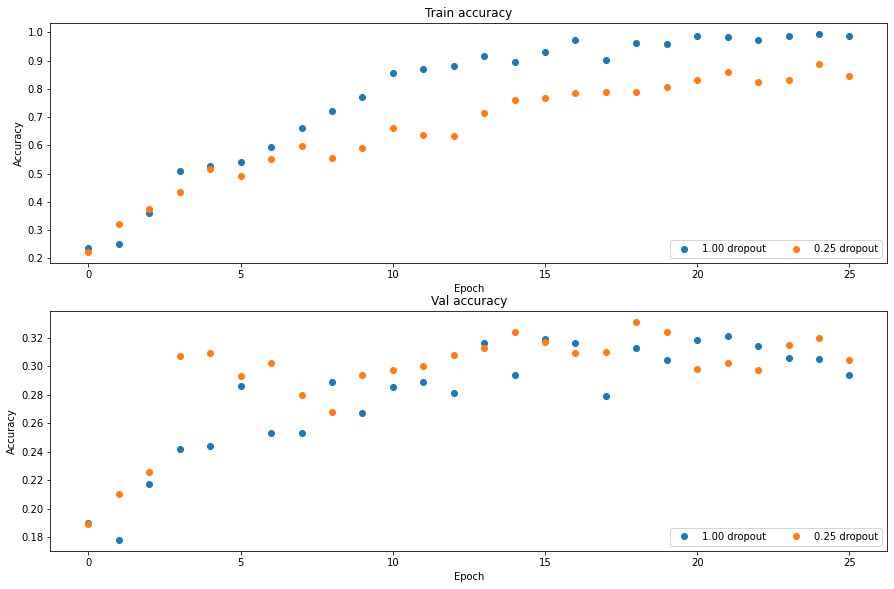

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## 问题 2:
对比有无dropout的验证和训练的精度，你对使用dropout作为正则化有何建议？

## 回答:
由于前几个epoch学到的还是渐层特征，所以dropout的负面影响远小于防止过拟合的正面影响，准确率显著增高，但是到后面训练深层特征时再使用高p的dropout，会影响识别些比较重要的特征，所以建议后层的dropout可采用类似学习率算法之类动态变化。另外，dropout的思想真的不错。CV预处理图片时使用的cutout方法就借鉴了dropout的思想，随机将图片挖掉一小块，会提升训练效果。我在矿石识别项目上将图片切成小块重新排列，也在最初的模型中提升了2%左右的准确率，这样避免了识别岩石的轮廓。


## 问题三 3:
假设我们正在训练一个深层的全连接网络用以进行图像分类，并隐层之后dropout（通过使用概率p进行参数化）。如果我们担心过度拟合而决定减小隐层的大小（即每层中的节点数）时，应该如何修改p（如果有的话）？

## 回答:
减小p，本来模型就小，维持p会损失太多重要特征信息。


---
# 重要

这里是作业的结尾处，请执行以下步骤:

1. 点击`File -> Save`或者用`control+s`组合键，确保你最新的的notebook的作业已经保存到谷歌云。
2. 执行以下代码确保 `.py` 文件保存回你的谷歌云。

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['daseCV/classifiers/cnn.py', 'daseCV/classifiers/fc_net.py',\
                 'daseCV/layers.py','daseCV/optim.py',\
                 'daseCV/solver.py','daseCV/layer_utils.py',\
                 'daseCV/data_utils.py','daseCV/fast_layers.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))